In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For clustering
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
import gdown

#Google Drive file URLs and output file names
files_to_download = {
    "https://drive.google.com/file/d/1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE/view?usp=sharing": "Customers.csv",
    "https://drive.google.com/file/d/1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0/view?usp=sharing": "Products.csv",
    "https://drive.google.com/file/d/1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF/view?usp=sharing": "Transactions.csv"
}

# Function to extract file ID and download
def download_from_drive(url, output):
    file_id = url.split('/d/')[1].split('/view')[0]
    download_url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(download_url, output, quiet=False)

# Download each file
for url, output in files_to_download.items():
    download_from_drive(url, output)

print("Files downloaded successfully!")


Downloading...
From: https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE
To: /content/Customers.csv
100%|██████████| 8.54k/8.54k [00:00<00:00, 12.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0
To: /content/Products.csv
100%|██████████| 4.25k/4.25k [00:00<00:00, 9.76MB/s]
Downloading...
From: https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF
To: /content/Transactions.csv
100%|██████████| 54.7k/54.7k [00:00<00:00, 57.3MB/s]

Files downloaded successfully!


In [4]:
# Read CSV files
customers_df = pd.read_csv("Customers.csv")
products_df = pd.read_csv("Products.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Merge Transactions with Customers and Products for broader analysis
transactions_merged = pd.merge(transactions_df, customers_df, on="CustomerID", how="left")
transactions_merged = pd.merge(transactions_merged, products_df, on="ProductID", how="left")

# Convert dates to datetime if not already
transactions_merged['TransactionDate'] = pd.to_datetime(transactions_merged['TransactionDate'])
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])


In [5]:
# Calculate customer-level aggregates from transactions
customer_agg = transactions_merged.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count'
}).rename(columns={
    'TotalValue': 'TotalSpend',
    'TransactionID': 'NumTransactions'
}).reset_index()

# Average purchase value
customer_agg['AvgPurchaseValue'] = customer_agg['TotalSpend'] / customer_agg['NumTransactions']

# Merge region info
customer_agg = pd.merge(customer_agg, customers_df[['CustomerID','Region']], on='CustomerID', how='left')

# Encode region (simple one-hot or label encoding)
customer_agg = pd.get_dummies(customer_agg, columns=['Region'])

In [6]:
# Prepare feature matrix
feature_cols = ['TotalSpend', 'NumTransactions', 'AvgPurchaseValue'] + \
               [col for col in customer_agg.columns if col.startswith('Region_')]
X = customer_agg[feature_cols].values

# Scale
scaler = StandardScaler()
X_for_clustering = scaler.fit_transform(X)

In [7]:
dbi_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_for_clustering)
    dbi = davies_bouldin_score(X_for_clustering, labels)
    dbi_scores.append(dbi)
    print(f"K={k}, DB Index={dbi:.4f}")

# Choose the best k (lowest DB Index)
best_k = cluster_range[np.argmin(dbi_scores)]
print(f"\nBest K based on minimum DB Index is: {best_k}")


K=2, DB Index=1.9845
K=3, DB Index=1.6344
K=4, DB Index=1.2365
K=5, DB Index=0.9161
K=6, DB Index=0.8598
K=7, DB Index=0.8535
K=8, DB Index=0.8830
K=9, DB Index=0.9296
K=10, DB Index=0.9161

Best K based on minimum DB Index is: 7


In [8]:
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
final_labels = kmeans_final.fit_predict(X_for_clustering)

# Save labels
customer_agg['Cluster'] = final_labels

# Compute final DBI
final_dbi = davies_bouldin_score(X_for_clustering, final_labels)
print("Final Davies-Bouldin Index:", final_dbi)


Final Davies-Bouldin Index: 0.8534855872369365


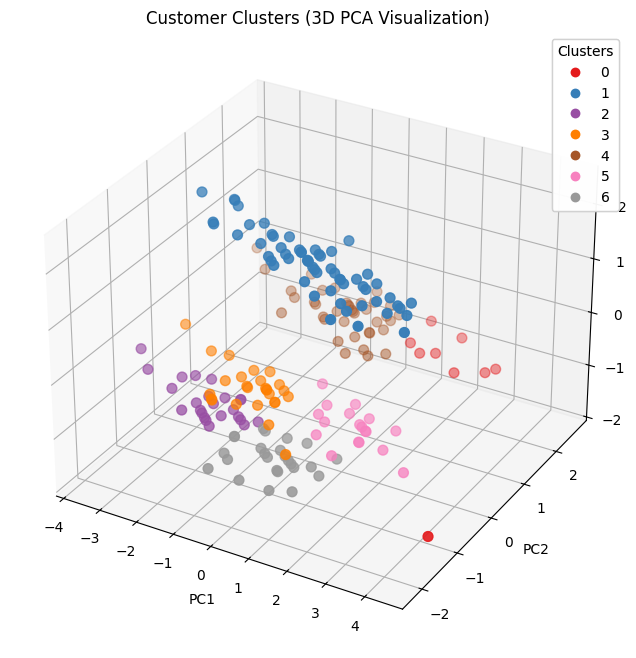

In [11]:
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Perform PCA with 3 components
pca_3d = PCA(n_components=3)
reduced_coords_3d = pca_3d.fit_transform(X_for_clustering)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    reduced_coords_3d[:, 0],
    reduced_coords_3d[:, 1],
    reduced_coords_3d[:, 2],
    c=final_labels,
    cmap="Set1",
    s=50
)

# Add legend
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

# Labels and title
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Customer Clusters (3D PCA Visualization)")

plt.show()


In [10]:
# Print cluster counts
cluster_counts = customer_agg['Cluster'].value_counts()
print("Cluster Counts:\n", cluster_counts)

# Summaries by cluster
cluster_summary = customer_agg.groupby('Cluster').agg({
    'TotalSpend': ['mean','sum'],
    'NumTransactions': 'mean',
    'AvgPurchaseValue': 'mean'
})
cluster_summary


Cluster Counts:
 Cluster
1    59
4    38
3    26
6    25
2    24
5    18
0     9
Name: count, dtype: int64


TotalSpend            NumTransactions AvgPurchaseValue
                mean        sum            mean             mean
Cluster                                                         
0        6606.106667   59454.96        9.111111       734.487559
1        3717.840000  219352.56        5.152542       700.667556
2        1857.147083   44571.53        3.791667       489.026375
3        2124.869231   55246.60        3.192308       691.647244
4        2724.534474  103532.31        4.526316       628.815897
5        5379.353889   96828.37        7.500000       736.287599
6        4440.369200  111009.23        5.320000       880.441607